In [1]:
!pip install transformers
!pip install pyyaml h5py

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import random
from random import shuffle

import itertools

import IPython.display as ipd

import time
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Model, Sequential, load_model
from keras.layers import Flatten, Dense, Lambda, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/drive/MyDrive/solder/trainval.zip'

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: trainval/train/normal/normal_b2 (462).tiff  
  inflating: __MACOSX/trainval/train/normal/._normal_b2 (462).tiff  
  inflating: trainval/train/normal/normal_b1 (278).tiff  
  inflating: __MACOSX/trainval/train/normal/._normal_b1 (278).tiff  
  inflating: trainval/train/normal/normal_b2 (45).tiff  
  inflating: __MACOSX/trainval/train/normal/._normal_b2 (45).tiff  
  inflating: trainval/train/normal/normal_b2 (683).tiff  
  inflating: __MACOSX/trainval/train/normal/._normal_b2 (683).tiff  
  inflating: trainval/train/normal/normal_b2 (252).tiff  
  inflating: __MACOSX/trainval/train/normal/._normal_b2 (252).tiff  
  inflating: trainval/train/normal/normal_b2 (1888).tiff  
  inflating: __MACOSX/trainval/train/normal/._normal_b2 (1888).tiff  
  inflating: trainval/train/normal/normal_b2 (1337).tiff  
  inflating: __MACOSX/trainval/train/normal/._normal_b2 (1337).tiff  
  inflating: trainval/train/normal/normal_b2 (1372).tiff  
  inflating: __MACOSX/t

In [5]:
#tf.debugging.set_log_device_placement(True)

print(tf.__version__)
print('Available GPUs: ', tf.config.list_physical_devices('GPU'))
print(tf.config.experimental.list_logical_devices('GPU'))
print(tf.test.gpu_device_name())

2.14.0
Available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
/device:GPU:0


In [6]:
seed = 1337

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

batch_size = 64
target_size = (224, 224)

train_gen = image.ImageDataGenerator(rescale = 1./255,
                               rotation_range=10,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest',
                               #preprocessing_function=lambda x: smart_resize(x, target_size)
                               )

valtest_gen = image.ImageDataGenerator(rescale = 1./255,
                                       fill_mode='nearest',
                                       #preprocessing_function=lambda x: smart_resize(x, target_size)
                                       )

batches = train_gen.flow_from_directory('trainval/train',
                                  target_size=target_size,
                                  # color_mode="rgb",
                                   batch_size=batch_size,
                                  class_mode='categorical',
                                  shuffle=False,
                                        seed = seed)

val_batches = valtest_gen.flow_from_directory('trainval/val',
                                      target_size=target_size,
                                      # color_mode="rgb",
                                       batch_size=batch_size,
                                      class_mode='categorical',
                                      shuffle=False,
                                              seed = seed)

Found 2878 images belonging to 5 classes.
Found 511 images belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:202: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn(


In [7]:
resnet = ResNet50(include_top=True,
                  weights='imagenet',
                  input_tensor=None,
                  input_shape=(224,224,3),
                  pooling=None)

x = resnet.layers[-2].output
output_layer = Dense(5, activation='softmax', name='predictions')(x)

model = Model(inputs=resnet.input, outputs=output_layer)

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='acc'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

model.compile(optimizer=Adam(learning_rate=1e-4),
                loss='categorical_crossentropy', metrics=METRICS)

epochs = 50

lr_scheduler = LearningRateScheduler(lambda x: 1e-4 * 0.9 ** x)

with tf.device('/GPU:0'):
    history = model.fit(batches,
              validation_data = val_batches,
              epochs = epochs,
              callbacks=lr_scheduler,
              class_weight = {0: 3.,
                1: 2.,
                2: 1.,
                3: 3.,
                4: 2.})
model.summary()
model.save('/content/drive/MyDrive/solder/model/resnetbase2.h5')


102967424/102967424 [==============================] - 1s 0us/step
Epoch 1/50
45/45 [==============================] - 100s 1s/step - loss: 1.6440 - acc: 0.7856 - precision: 0.8397 - recall: 0.7318 - auc: 0.9008 - val_loss: 2.5932 - val_acc: 0.0881 - val_precision: 0.0881 - val_recall: 0.0881 - val_auc: 0.5309 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 53s 1s/step - loss: 1.0004 - acc: 0.8513 - precision: 0.9361 - recall: 0.8047 - auc: 0.9683 - val_loss: 0.8650 - val_acc: 0.8043 - val_precision: 0.8043 - val_recall: 0.8043 - val_auc: 0.8834 - lr: 9.0000e-05
Epoch 3/50
45/45 [==============================] - 54s 1s/step - loss: 0.6490 - acc: 0.9006 - precision: 0.9809 - recall: 0.8367 - auc: 0.9907 - val_loss: 1.8603 - val_acc: 0.0881 - val_precision: 0.0881 - val_recall: 0.0881 - val_auc: 0.7251 - lr: 8.1000e-05
Epoch 4/50
45/45 [==============================] - 54s 1s/step - loss: 0.4570 - acc: 0.9305 - precision: 0.9599 - recall: 0.9072 - auc: 0.9957 - val

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


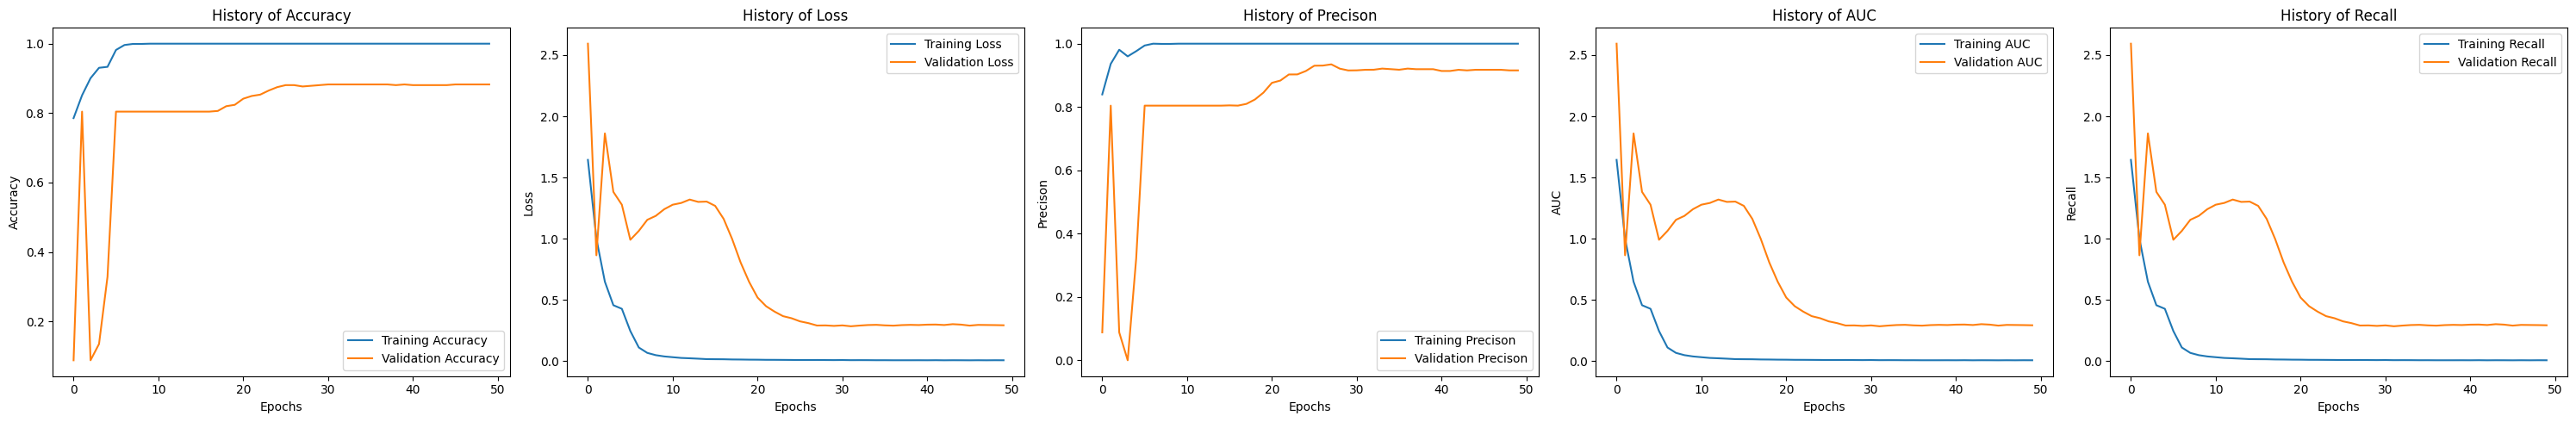

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

auc = history.history['auc']
val_auc = history.history['val_auc']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['recall']

epochs_range = range(epochs)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize= (30,5))

ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

ax3.plot(epochs_range, precision, label='Training Precison')
ax3.plot(epochs_range, val_precision, label='Validation Precison')
ax3.set_title('History of Precison')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Precison')

ax4.plot(epochs_range, loss, label='Training AUC')
ax4.plot(epochs_range, val_loss, label='Validation AUC')
ax4.set_title('History of AUC')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('AUC')

ax5.plot(epochs_range, loss, label='Training Recall')
ax5.plot(epochs_range, val_loss, label='Validation Recall')
ax5.set_title('History of Recall')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('Recall')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
fig.tight_layout()

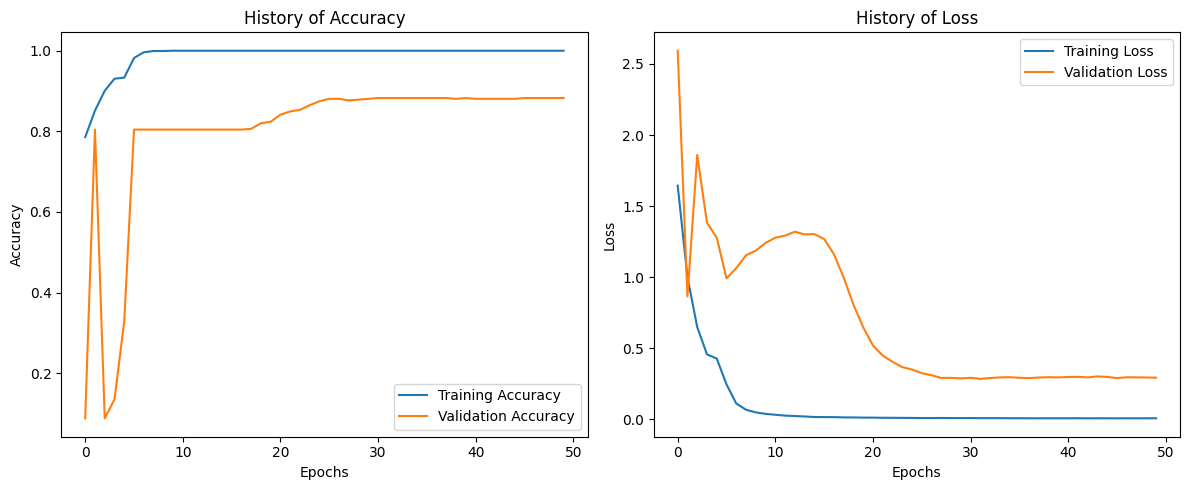

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize= (12,5))

ax1.plot(epochs_range, acc, label='Training Accuracy')
ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2.plot(epochs_range, loss, label='Training Loss')
ax2.plot(epochs_range, val_loss, label='Validation Loss')
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

ax1.legend()
ax2.legend()
fig.tight_layout()


<ipython-input-10-3bf2d159b306>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(val_batches, val_batches.samples // batch_size+1)


Confusion Matrix
[[  8   4   2   0   0]
 [  0  18   4   1   0]
 [  0   0 411   0   0]
 [  1   1   3  10   3]
 [  3  12  22   4   4]]
Classification Report
                     precision    recall  f1-score   support

   excessive_solder       0.67      0.57      0.62        14
insufficient_solder       0.51      0.78      0.62        23
             normal       0.93      1.00      0.96       411
  shifted_component       0.67      0.56      0.61        18
              short       0.57      0.09      0.15        45

           accuracy                           0.88       511
          macro avg       0.67      0.60      0.59       511
       weighted avg       0.86      0.88      0.85       511



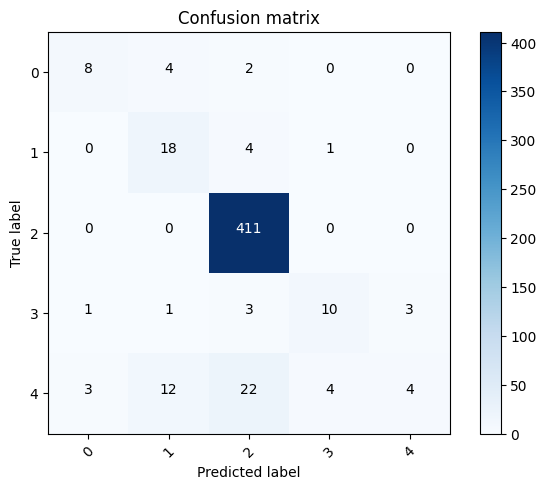

In [10]:
Y_pred = model.predict_generator(val_batches, val_batches.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
conf_matrix = confusion_matrix(val_batches.classes, y_pred)
print(conf_matrix)
np.savetxt("conf_matrix.csv", conf_matrix, delimiter=",", fmt="%s")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(conf_matrix, classes = range(5))

print('Classification Report')
target_names = np.array(list(val_batches.class_indices.keys()))
print(classification_report(val_batches.classes, y_pred, target_names=target_names))